In [20]:
"""
#Amount google drive
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/case_study_opti/latent-communication'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
# LMU is not a rwal university <3
print(sorted(os.listdir()))

#!pip install lightning
#!pip install omegaconf
"""
import os 
# Set working directory
#Get working directory
print(os.getcwd())
os.chdir("/Users/mariotuci/Desktop/Latent-Communication/latent-communication/")

/Users/mariotuci/Desktop/Latent-Communication/latent-communication


In [21]:
from pathlib import Path
import torch.nn as nn
import os
import itertools
import torch
import numpy as np
from tqdm import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from utils.dataloaders.full_dataloaders import DataLoaderMNIST, DataLoaderFashionMNIST, DataLoaderCIFAR10, DataLoaderCIFAR100
from utils.visualization import (
    visualize_mapping_error,
    visualize_latent_space_pca,
    plot_latent_space,
    highlight_cluster,
)
from utils.model import load_model, get_transformations

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    def __init__(self, **entries):
        self.__dict__.update(entries)


In [22]:
def clear_memory():
    torch.cuda.empty_cache()

def define_dataloader(file, file2, use_test_set=False):
    if file.strip("_")[0] != file2.strip("_")[0]:
        logging.error("The datasets are different")
    # Define the dataloaders
    name_dataset, name_model, size_of_the_latent, seed = file.strip(".pth").split("_")
    augumentation = get_transformations(name_model)
    if name_dataset.lower() == "mnist":
        dataloader = DataLoaderMNIST(transformation=augumentation, batch_size=64, seed=int(seed))
    if name_dataset.lower() == "fmnist":
        dataloader = DataLoaderFashionMNIST(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar10":
        dataloader = DataLoaderCIFAR10(transformation=augumentation,batch_size=64, seed=int(seed))
    if name_dataset.lower() == "cifar100":
        dataloader = DataLoaderCIFAR100(transformation=augumentation,batch_size=64, seed=int(seed))
    if use_test_set:
        full_dataset_images, full_dataset_labels = dataloader.get_full_test_dataset()
    else:
        full_dataset_images, full_dataset_labels = dataloader.get_full_train_dataset()
    return full_dataset_images, full_dataset_labels, len(np.unique(full_dataset_labels.numpy()))

def load_mapping(path,mapping):
    if mapping == 'Linear':
        from optimization.optimizer import LinearFitting
        mapping = LinearFitting.from_file(path)
    elif mapping == 'Affine':
        from optimization.optimizer import AffineFitting
        mapping = AffineFitting.from_file(path)
    elif mapping == 'NeuralNetwork':
        from optimization.optimizer import NeuralNetworkFitting
        mapping = NeuralNetworkFitting.from_file(path)
    else:
        raise ValueError("Invalid experiment name")
    return mapping

In [32]:
##############################################
#Specify here which files you want to use

folder1 = "models/checkpoints/VAE/FMNIST/"
folder2 = "models/checkpoints/VAE/FMNIST/"
dataset="FMNIST"
number_samples = [10,50,100,200]
mapping_list = ["Linear", "Affine"]
lamda_list = [0,0.1, 0.01, 0.001]
sampling_strategy = "equally"
filter = '_8_' #write here if you want that the processed files contain this string (example "_50_" to only process the files with latent size 50)
###############################################
## this autiomatically creates all the possible setups with the paramenters and the files you speicified, and sets up the correct dataset
files1 = [f for f in os.listdir(folder1) if f.endswith(".pth") and filter in f]
files2 = [f for f in os.listdir(folder2) if f.endswith(".pth") and filter in f]
print(files1)
list_of_files = [(f1, f2) for f1, f2 in itertools.product(files1, files2) if f1 != f2]
combinations_parameters = list(itertools.product(number_samples, mapping_list, lamda_list))
pbar = tqdm(list(itertools.product(list_of_files, combinations_parameters)))
images, labels, n_classes = define_dataloader(files1[0], files2[0], use_test_set=True)
images = images.type(torch.float32)
labels = labels.type(torch.float32)
criterion = nn.MSELoss()
results_list = []
for (file1, file2), (num_samples, mapping_name, lamda) in pbar:
  print(file1)
  name_dataset1, name_model1, size_of_the_latent1, seed1 = file1.strip(".pth").split("_")
  name_dataset2, name_model2, size_of_the_latent2, seed2 = file2.strip(".pth").split("_")
  #Load model
  model1 = load_model(model_name=name_model1, name_dataset=name_dataset1, latent_size=int(size_of_the_latent1), seed=int(seed1), model_path = folder1 + file1)
  model2 = load_model(model_name=name_model2, name_dataset=name_dataset2, latent_size=int(size_of_the_latent2), seed=int(seed2), model_path = folder1 + file2)
  #Load mapping
  mapping_path = f'results/transformations/mapping_files/{name_model2}/{file1.strip(".pth")}>{file2.strip(".pth")}>{mapping_name}_{num_samples}_{lamda}_{sampling_strategy}'
  mapping = load_mapping(mapping_path,mapping_name)
  #Calculate latent spaces
  latent_left = model1.get_latent_space(images).detach().cpu().numpy()
  latent_right = model2.get_latent_space(images).detach().cpu().numpy()
  transformed_latent_space = mapping.transform(latent_left)
  #Get stitched output
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  mse_loss = criterion(torch.tensor(decoded_transformed),images).item()
  #ssim_loss = ssim(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  #psnr_loss = psnr(images.detach().cpu().numpy(), decoded_transformed, data_range=decoded_transformed.max() - decoded_transformed.min())
  results_list.append({
    "dataset": dataset,
    "model1": file1,
    "model2": file2,
    "mapping": mapping_name,
    "lambda": lamda,
    "num_samples": num_samples,
    "MSE_loss": mse_loss,
    "class": None
    })

results = pd.DataFrame(results_list)

['FMNIST_VAE_8_3.pth', 'FMNIST_VAE_8_2.pth', 'FMNIST_VAE_8_1.pth']


  0%|          | 0/192 [00:00<?, ?it/s]

FMNIST_VAE_8_3.pth


/var/folders/yh/rbd67mcj2zd4nychzgcydvt40000gn/T/ipykernel_21973/3895155213.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decoded_transformed = model2.decode(torch.tensor(transformed_latent_space, dtype=torch.float32).to(images.device)).detach().cpu().numpy()
  1%|          | 1/192 [00:05<17:00,  5.34s/it]

FMNIST_VAE_8_3.pth


  1%|          | 2/192 [00:07<10:03,  3.18s/it]

FMNIST_VAE_8_3.pth


  2%|▏         | 3/192 [00:08<07:52,  2.50s/it]

FMNIST_VAE_8_3.pth


  2%|▏         | 4/192 [00:10<06:52,  2.19s/it]

FMNIST_VAE_8_3.pth


  3%|▎         | 5/192 [00:12<06:16,  2.01s/it]

FMNIST_VAE_8_3.pth


  3%|▎         | 6/192 [00:13<05:53,  1.90s/it]

FMNIST_VAE_8_3.pth


  4%|▎         | 7/192 [00:15<05:35,  1.81s/it]

FMNIST_VAE_8_3.pth


  4%|▍         | 8/192 [00:17<05:25,  1.77s/it]

FMNIST_VAE_8_3.pth


  5%|▍         | 9/192 [00:19<05:33,  1.82s/it]

FMNIST_VAE_8_3.pth


  5%|▌         | 10/192 [00:20<05:22,  1.77s/it]

FMNIST_VAE_8_3.pth


  6%|▌         | 11/192 [00:22<05:08,  1.71s/it]

FMNIST_VAE_8_3.pth


  6%|▋         | 12/192 [00:23<04:59,  1.67s/it]

FMNIST_VAE_8_3.pth


  7%|▋         | 13/192 [00:25<04:53,  1.64s/it]

FMNIST_VAE_8_3.pth


  7%|▋         | 14/192 [00:26<04:48,  1.62s/it]

FMNIST_VAE_8_3.pth


  8%|▊         | 15/192 [00:28<04:44,  1.60s/it]

FMNIST_VAE_8_3.pth


  8%|▊         | 16/192 [00:30<04:39,  1.59s/it]

FMNIST_VAE_8_3.pth


  9%|▉         | 17/192 [00:31<04:37,  1.59s/it]

FMNIST_VAE_8_3.pth


  9%|▉         | 18/192 [00:33<04:53,  1.69s/it]

FMNIST_VAE_8_3.pth


 10%|▉         | 19/192 [00:35<04:53,  1.70s/it]

FMNIST_VAE_8_3.pth


 10%|█         | 20/192 [00:36<04:47,  1.67s/it]

FMNIST_VAE_8_3.pth


 11%|█         | 21/192 [00:38<04:42,  1.65s/it]

FMNIST_VAE_8_3.pth


 11%|█▏        | 22/192 [00:40<04:37,  1.63s/it]

FMNIST_VAE_8_3.pth


 12%|█▏        | 23/192 [00:41<04:32,  1.61s/it]

FMNIST_VAE_8_3.pth


 12%|█▎        | 24/192 [00:43<04:31,  1.62s/it]

FMNIST_VAE_8_3.pth


 13%|█▎        | 25/192 [00:44<04:28,  1.61s/it]

FMNIST_VAE_8_3.pth


 14%|█▎        | 26/192 [00:46<04:25,  1.60s/it]

FMNIST_VAE_8_3.pth


 14%|█▍        | 27/192 [00:48<04:25,  1.61s/it]

FMNIST_VAE_8_3.pth


 15%|█▍        | 28/192 [00:49<04:22,  1.60s/it]

FMNIST_VAE_8_3.pth


 15%|█▌        | 29/192 [00:51<04:21,  1.60s/it]

FMNIST_VAE_8_3.pth


 16%|█▌        | 30/192 [00:52<04:19,  1.60s/it]

FMNIST_VAE_8_3.pth


 16%|█▌        | 31/192 [00:54<04:17,  1.60s/it]

FMNIST_VAE_8_3.pth


 17%|█▋        | 32/192 [00:56<04:18,  1.62s/it]

FMNIST_VAE_8_3.pth


 17%|█▋        | 33/192 [00:57<04:16,  1.61s/it]

FMNIST_VAE_8_3.pth


 18%|█▊        | 34/192 [00:59<04:13,  1.61s/it]

FMNIST_VAE_8_3.pth


 18%|█▊        | 35/192 [01:00<04:12,  1.61s/it]

FMNIST_VAE_8_3.pth


 19%|█▉        | 36/192 [01:02<04:10,  1.60s/it]

FMNIST_VAE_8_3.pth


 19%|█▉        | 37/192 [01:04<04:09,  1.61s/it]

FMNIST_VAE_8_3.pth


 20%|█▉        | 38/192 [01:05<04:07,  1.61s/it]

FMNIST_VAE_8_3.pth


 20%|██        | 39/192 [01:07<04:05,  1.60s/it]

FMNIST_VAE_8_3.pth


 21%|██        | 40/192 [01:08<04:03,  1.60s/it]

FMNIST_VAE_8_3.pth


 21%|██▏       | 41/192 [01:10<04:01,  1.60s/it]

FMNIST_VAE_8_3.pth


 22%|██▏       | 42/192 [01:12<03:59,  1.60s/it]

FMNIST_VAE_8_3.pth


 22%|██▏       | 43/192 [01:13<03:57,  1.59s/it]

FMNIST_VAE_8_3.pth


 23%|██▎       | 44/192 [01:15<03:55,  1.59s/it]

FMNIST_VAE_8_3.pth


 23%|██▎       | 45/192 [01:16<03:53,  1.59s/it]

FMNIST_VAE_8_3.pth


 24%|██▍       | 46/192 [01:18<03:50,  1.58s/it]

FMNIST_VAE_8_3.pth


 24%|██▍       | 47/192 [01:20<03:49,  1.58s/it]

FMNIST_VAE_8_3.pth


 25%|██▌       | 48/192 [01:21<04:01,  1.67s/it]

FMNIST_VAE_8_3.pth


 26%|██▌       | 49/192 [01:24<04:26,  1.87s/it]

FMNIST_VAE_8_3.pth


 26%|██▌       | 50/192 [01:26<04:24,  1.87s/it]

FMNIST_VAE_8_3.pth


 27%|██▋       | 51/192 [01:27<04:16,  1.82s/it]

FMNIST_VAE_8_3.pth


 27%|██▋       | 52/192 [01:29<04:08,  1.77s/it]

FMNIST_VAE_8_3.pth


 28%|██▊       | 53/192 [01:31<04:02,  1.74s/it]

FMNIST_VAE_8_3.pth


 28%|██▊       | 54/192 [01:32<03:57,  1.72s/it]

FMNIST_VAE_8_3.pth


 29%|██▊       | 55/192 [01:34<03:52,  1.70s/it]

FMNIST_VAE_8_3.pth


 29%|██▉       | 56/192 [01:36<03:48,  1.68s/it]

FMNIST_VAE_8_3.pth


 30%|██▉       | 57/192 [01:37<03:43,  1.66s/it]

FMNIST_VAE_8_3.pth


 30%|███       | 58/192 [01:39<03:37,  1.63s/it]

FMNIST_VAE_8_3.pth


 31%|███       | 59/192 [01:40<03:33,  1.60s/it]

FMNIST_VAE_8_3.pth


 31%|███▏      | 60/192 [01:42<03:39,  1.66s/it]

FMNIST_VAE_8_3.pth


 32%|███▏      | 61/192 [01:44<03:48,  1.75s/it]

FMNIST_VAE_8_3.pth


 32%|███▏      | 62/192 [01:46<04:05,  1.89s/it]

FMNIST_VAE_8_3.pth


 33%|███▎      | 63/192 [01:49<04:15,  1.98s/it]

FMNIST_VAE_8_3.pth


 33%|███▎      | 64/192 [01:51<04:15,  1.99s/it]

FMNIST_VAE_8_2.pth


 34%|███▍      | 65/192 [01:53<04:13,  2.00s/it]

FMNIST_VAE_8_2.pth


 34%|███▍      | 66/192 [01:54<04:05,  1.95s/it]

FMNIST_VAE_8_2.pth


 35%|███▍      | 67/192 [01:56<03:54,  1.87s/it]

FMNIST_VAE_8_2.pth


 35%|███▌      | 68/192 [01:58<03:47,  1.83s/it]

FMNIST_VAE_8_2.pth


 36%|███▌      | 69/192 [02:00<03:51,  1.88s/it]

FMNIST_VAE_8_2.pth


 36%|███▋      | 70/192 [02:02<03:55,  1.93s/it]

FMNIST_VAE_8_2.pth


 37%|███▋      | 71/192 [02:04<03:52,  1.92s/it]

FMNIST_VAE_8_2.pth


 38%|███▊      | 72/192 [02:06<03:47,  1.90s/it]

FMNIST_VAE_8_2.pth


 38%|███▊      | 73/192 [02:08<03:46,  1.90s/it]

FMNIST_VAE_8_2.pth


 39%|███▊      | 74/192 [02:09<03:45,  1.91s/it]

FMNIST_VAE_8_2.pth


 39%|███▉      | 75/192 [02:11<03:48,  1.96s/it]

FMNIST_VAE_8_2.pth


 40%|███▉      | 76/192 [02:14<03:57,  2.04s/it]

FMNIST_VAE_8_2.pth


 40%|████      | 77/192 [02:16<03:50,  2.00s/it]

FMNIST_VAE_8_2.pth


 41%|████      | 78/192 [02:17<03:41,  1.94s/it]

FMNIST_VAE_8_2.pth


 41%|████      | 79/192 [02:19<03:31,  1.87s/it]

FMNIST_VAE_8_2.pth


 42%|████▏     | 80/192 [02:21<03:22,  1.81s/it]

FMNIST_VAE_8_2.pth


 42%|████▏     | 81/192 [02:23<03:18,  1.79s/it]

FMNIST_VAE_8_2.pth


 43%|████▎     | 82/192 [02:24<03:12,  1.75s/it]

FMNIST_VAE_8_2.pth


 43%|████▎     | 83/192 [02:26<03:07,  1.72s/it]

FMNIST_VAE_8_2.pth


 44%|████▍     | 84/192 [02:28<03:03,  1.70s/it]

FMNIST_VAE_8_2.pth


 44%|████▍     | 85/192 [02:29<02:59,  1.68s/it]

FMNIST_VAE_8_2.pth


 45%|████▍     | 86/192 [02:31<02:56,  1.67s/it]

FMNIST_VAE_8_2.pth


 45%|████▌     | 87/192 [02:32<02:53,  1.65s/it]

FMNIST_VAE_8_2.pth


 46%|████▌     | 88/192 [02:34<02:51,  1.64s/it]

FMNIST_VAE_8_2.pth


 46%|████▋     | 89/192 [02:36<02:48,  1.64s/it]

FMNIST_VAE_8_2.pth


 47%|████▋     | 90/192 [02:37<02:47,  1.64s/it]

FMNIST_VAE_8_2.pth


 47%|████▋     | 91/192 [02:39<02:44,  1.63s/it]

FMNIST_VAE_8_2.pth


 48%|████▊     | 92/192 [02:40<02:41,  1.62s/it]

FMNIST_VAE_8_2.pth


 48%|████▊     | 93/192 [02:42<02:39,  1.61s/it]

FMNIST_VAE_8_2.pth


 49%|████▉     | 94/192 [02:44<02:36,  1.60s/it]

FMNIST_VAE_8_2.pth


 49%|████▉     | 95/192 [02:46<02:46,  1.72s/it]

FMNIST_VAE_8_2.pth


 50%|█████     | 96/192 [02:48<02:58,  1.86s/it]

FMNIST_VAE_8_2.pth


 51%|█████     | 97/192 [02:50<02:55,  1.84s/it]

FMNIST_VAE_8_2.pth


 51%|█████     | 98/192 [02:51<02:50,  1.82s/it]

FMNIST_VAE_8_2.pth


 52%|█████▏    | 99/192 [02:53<02:46,  1.79s/it]

FMNIST_VAE_8_2.pth


 52%|█████▏    | 100/192 [02:55<02:42,  1.76s/it]

FMNIST_VAE_8_2.pth


 53%|█████▎    | 101/192 [02:57<02:40,  1.76s/it]

FMNIST_VAE_8_2.pth


 53%|█████▎    | 102/192 [02:58<02:35,  1.73s/it]

FMNIST_VAE_8_2.pth


 54%|█████▎    | 103/192 [03:00<02:31,  1.70s/it]

FMNIST_VAE_8_2.pth


 54%|█████▍    | 104/192 [03:02<02:28,  1.68s/it]

FMNIST_VAE_8_2.pth


 55%|█████▍    | 105/192 [03:04<02:34,  1.78s/it]

FMNIST_VAE_8_2.pth


 55%|█████▌    | 106/192 [03:05<02:31,  1.77s/it]

FMNIST_VAE_8_2.pth


 56%|█████▌    | 107/192 [03:07<02:26,  1.73s/it]

FMNIST_VAE_8_2.pth


 56%|█████▋    | 108/192 [03:09<02:23,  1.71s/it]

FMNIST_VAE_8_2.pth


 57%|█████▋    | 109/192 [03:10<02:18,  1.67s/it]

FMNIST_VAE_8_2.pth


 57%|█████▋    | 110/192 [03:12<02:14,  1.64s/it]

FMNIST_VAE_8_2.pth


 58%|█████▊    | 111/192 [03:13<02:11,  1.62s/it]

FMNIST_VAE_8_2.pth


 58%|█████▊    | 112/192 [03:15<02:07,  1.60s/it]

FMNIST_VAE_8_2.pth


 59%|█████▉    | 113/192 [03:16<02:06,  1.60s/it]

FMNIST_VAE_8_2.pth


 59%|█████▉    | 114/192 [03:18<02:04,  1.59s/it]

FMNIST_VAE_8_2.pth


 60%|█████▉    | 115/192 [03:20<02:02,  1.59s/it]

FMNIST_VAE_8_2.pth


 60%|██████    | 116/192 [03:21<02:00,  1.59s/it]

FMNIST_VAE_8_2.pth


 61%|██████    | 117/192 [03:23<01:58,  1.59s/it]

FMNIST_VAE_8_2.pth


 61%|██████▏   | 118/192 [03:24<01:58,  1.60s/it]

FMNIST_VAE_8_2.pth


 62%|██████▏   | 119/192 [03:26<01:57,  1.60s/it]

FMNIST_VAE_8_2.pth


 62%|██████▎   | 120/192 [03:28<01:56,  1.61s/it]

FMNIST_VAE_8_2.pth


 63%|██████▎   | 121/192 [03:29<01:55,  1.62s/it]

FMNIST_VAE_8_2.pth


 64%|██████▎   | 122/192 [03:31<01:53,  1.62s/it]

FMNIST_VAE_8_2.pth


 64%|██████▍   | 123/192 [03:33<01:52,  1.64s/it]

FMNIST_VAE_8_2.pth


 65%|██████▍   | 124/192 [03:35<02:00,  1.77s/it]

FMNIST_VAE_8_2.pth


 65%|██████▌   | 125/192 [03:36<01:58,  1.76s/it]

FMNIST_VAE_8_2.pth


 66%|██████▌   | 126/192 [03:38<01:54,  1.74s/it]

FMNIST_VAE_8_2.pth


 66%|██████▌   | 127/192 [03:40<01:52,  1.72s/it]

FMNIST_VAE_8_2.pth


 67%|██████▋   | 128/192 [03:41<01:49,  1.72s/it]

FMNIST_VAE_8_1.pth


 67%|██████▋   | 129/192 [03:43<01:47,  1.70s/it]

FMNIST_VAE_8_1.pth


 68%|██████▊   | 130/192 [03:45<01:46,  1.71s/it]

FMNIST_VAE_8_1.pth


 68%|██████▊   | 131/192 [03:47<01:51,  1.82s/it]

FMNIST_VAE_8_1.pth


 69%|██████▉   | 132/192 [03:49<01:48,  1.81s/it]

FMNIST_VAE_8_1.pth


 69%|██████▉   | 133/192 [03:50<01:45,  1.78s/it]

FMNIST_VAE_8_1.pth


 70%|██████▉   | 134/192 [03:52<01:41,  1.75s/it]

FMNIST_VAE_8_1.pth


 70%|███████   | 135/192 [03:54<01:38,  1.73s/it]

FMNIST_VAE_8_1.pth


 71%|███████   | 136/192 [03:55<01:35,  1.71s/it]

FMNIST_VAE_8_1.pth


 71%|███████▏  | 137/192 [03:57<01:32,  1.69s/it]

FMNIST_VAE_8_1.pth


 72%|███████▏  | 138/192 [03:59<01:30,  1.67s/it]

FMNIST_VAE_8_1.pth


 72%|███████▏  | 139/192 [04:00<01:27,  1.65s/it]

FMNIST_VAE_8_1.pth


 73%|███████▎  | 140/192 [04:02<01:25,  1.65s/it]

FMNIST_VAE_8_1.pth


 73%|███████▎  | 141/192 [04:04<01:23,  1.64s/it]

FMNIST_VAE_8_1.pth


 74%|███████▍  | 142/192 [04:05<01:21,  1.63s/it]

FMNIST_VAE_8_1.pth


 74%|███████▍  | 143/192 [04:07<01:19,  1.63s/it]

FMNIST_VAE_8_1.pth


 75%|███████▌  | 144/192 [04:08<01:18,  1.63s/it]

FMNIST_VAE_8_1.pth


 76%|███████▌  | 145/192 [04:10<01:16,  1.63s/it]

FMNIST_VAE_8_1.pth


 76%|███████▌  | 146/192 [04:12<01:14,  1.63s/it]

FMNIST_VAE_8_1.pth


 77%|███████▋  | 147/192 [04:13<01:13,  1.63s/it]

FMNIST_VAE_8_1.pth


 77%|███████▋  | 148/192 [04:15<01:11,  1.63s/it]

FMNIST_VAE_8_1.pth


 78%|███████▊  | 149/192 [04:17<01:10,  1.63s/it]

FMNIST_VAE_8_1.pth


 78%|███████▊  | 150/192 [04:18<01:08,  1.63s/it]

FMNIST_VAE_8_1.pth


 79%|███████▊  | 151/192 [04:20<01:06,  1.61s/it]

FMNIST_VAE_8_1.pth


 79%|███████▉  | 152/192 [04:21<01:04,  1.61s/it]

FMNIST_VAE_8_1.pth


 80%|███████▉  | 153/192 [04:24<01:08,  1.76s/it]

FMNIST_VAE_8_1.pth


 80%|████████  | 154/192 [04:26<01:10,  1.85s/it]

FMNIST_VAE_8_1.pth


 81%|████████  | 155/192 [04:27<01:07,  1.83s/it]

FMNIST_VAE_8_1.pth


 81%|████████▏ | 156/192 [04:29<01:03,  1.78s/it]

FMNIST_VAE_8_1.pth


 82%|████████▏ | 157/192 [04:31<01:00,  1.74s/it]

FMNIST_VAE_8_1.pth


 82%|████████▏ | 158/192 [04:32<00:58,  1.71s/it]

FMNIST_VAE_8_1.pth


 83%|████████▎ | 159/192 [04:34<00:55,  1.69s/it]

FMNIST_VAE_8_1.pth


 83%|████████▎ | 160/192 [04:36<00:54,  1.71s/it]

FMNIST_VAE_8_1.pth


 84%|████████▍ | 161/192 [04:38<00:56,  1.81s/it]

FMNIST_VAE_8_1.pth


 84%|████████▍ | 162/192 [04:40<00:54,  1.80s/it]

FMNIST_VAE_8_1.pth


 85%|████████▍ | 163/192 [04:41<00:50,  1.76s/it]

FMNIST_VAE_8_1.pth


 85%|████████▌ | 164/192 [04:43<00:49,  1.75s/it]

FMNIST_VAE_8_1.pth


 86%|████████▌ | 165/192 [04:45<00:45,  1.70s/it]

FMNIST_VAE_8_1.pth


 86%|████████▋ | 166/192 [04:46<00:43,  1.66s/it]

FMNIST_VAE_8_1.pth


 87%|████████▋ | 167/192 [04:48<00:40,  1.63s/it]

FMNIST_VAE_8_1.pth


 88%|████████▊ | 168/192 [04:49<00:38,  1.62s/it]

FMNIST_VAE_8_1.pth


 88%|████████▊ | 169/192 [04:51<00:36,  1.60s/it]

FMNIST_VAE_8_1.pth


 89%|████████▊ | 170/192 [04:52<00:34,  1.58s/it]

FMNIST_VAE_8_1.pth


 89%|████████▉ | 171/192 [04:54<00:32,  1.57s/it]

FMNIST_VAE_8_1.pth


 90%|████████▉ | 172/192 [04:55<00:31,  1.56s/it]

FMNIST_VAE_8_1.pth


 90%|█████████ | 173/192 [04:57<00:31,  1.64s/it]

FMNIST_VAE_8_1.pth


 91%|█████████ | 174/192 [04:59<00:32,  1.79s/it]

FMNIST_VAE_8_1.pth


 91%|█████████ | 175/192 [05:01<00:31,  1.83s/it]

FMNIST_VAE_8_1.pth


 92%|█████████▏| 176/192 [05:04<00:31,  1.95s/it]

FMNIST_VAE_8_1.pth


 92%|█████████▏| 177/192 [05:05<00:28,  1.92s/it]

FMNIST_VAE_8_1.pth


 93%|█████████▎| 178/192 [05:07<00:26,  1.88s/it]

FMNIST_VAE_8_1.pth


 93%|█████████▎| 179/192 [05:09<00:23,  1.82s/it]

FMNIST_VAE_8_1.pth


 94%|█████████▍| 180/192 [05:11<00:21,  1.78s/it]

FMNIST_VAE_8_1.pth


 94%|█████████▍| 181/192 [05:12<00:19,  1.74s/it]

FMNIST_VAE_8_1.pth


 95%|█████████▍| 182/192 [05:14<00:17,  1.71s/it]

FMNIST_VAE_8_1.pth


 95%|█████████▌| 183/192 [05:15<00:15,  1.69s/it]

FMNIST_VAE_8_1.pth


 96%|█████████▌| 184/192 [05:17<00:13,  1.67s/it]

FMNIST_VAE_8_1.pth


 96%|█████████▋| 185/192 [05:19<00:11,  1.67s/it]

FMNIST_VAE_8_1.pth


 97%|█████████▋| 186/192 [05:20<00:09,  1.66s/it]

FMNIST_VAE_8_1.pth


 97%|█████████▋| 187/192 [05:22<00:08,  1.65s/it]

FMNIST_VAE_8_1.pth


 98%|█████████▊| 188/192 [05:24<00:06,  1.64s/it]

FMNIST_VAE_8_1.pth


 98%|█████████▊| 189/192 [05:25<00:04,  1.62s/it]

FMNIST_VAE_8_1.pth


 99%|█████████▉| 190/192 [05:27<00:03,  1.61s/it]

FMNIST_VAE_8_1.pth


 99%|█████████▉| 191/192 [05:28<00:01,  1.60s/it]

FMNIST_VAE_8_1.pth


100%|██████████| 192/192 [05:30<00:00,  1.72s/it]


In [33]:
#Save results somewhere: TODO change path
path_result="results_stitching.csv"
results.to_csv(path_result)

In [34]:
results

,dataset,model1,model2,mapping,lambda,num_samples,MSE_loss,class
0,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.000,10,0.878196,None
1,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.100,10,0.317061,None
2,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.010,10,0.344062,None
3,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Linear,0.001,10,0.355505,None
4,FMNIST,FMNIST_VAE_8_3.pth,FMNIST_VAE_8_2.pth,Affine,0.000,10,0.749953,None
...,...,...,...,...,...,...,...,...
187,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Linear,0.001,200,0.408788,None
188,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Affine,0.000,200,0.109586,None
189,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Affine,0.100,200,0.387613,None
190,FMNIST,FMNIST_VAE_8_1.pth,FMNIST_VAE_8_2.pth,Affine,0.010,200,0.396152,None


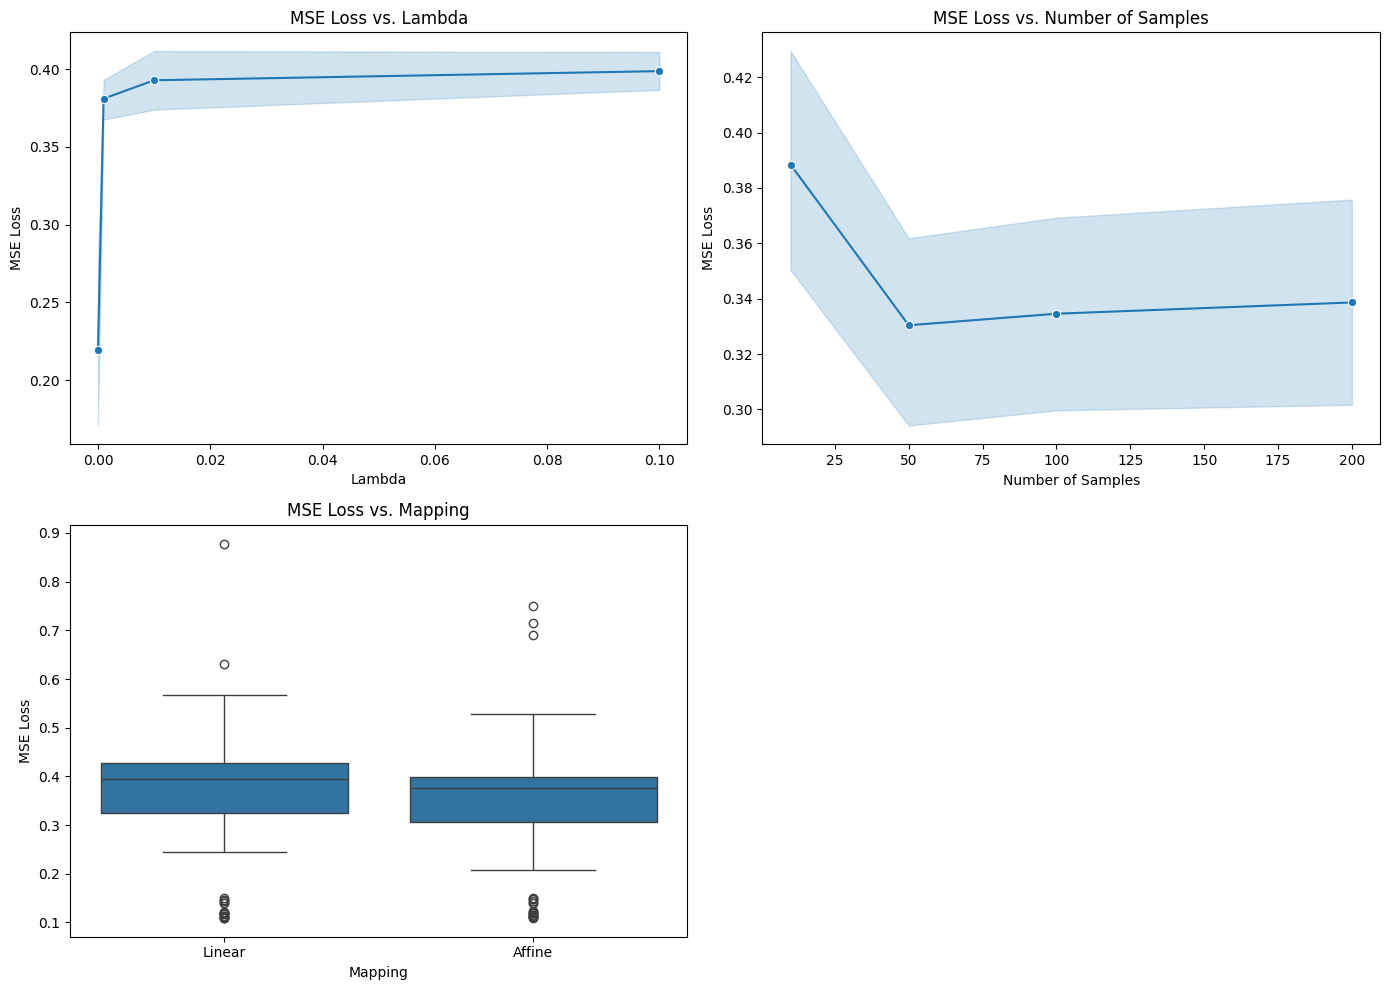

In [35]:
# Plotting
plt.figure(figsize=(14, 10))

# Plot MSE_loss vs. lambda
plt.subplot(2, 2, 1)
sns.lineplot(data=results, x='lambda', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. num_samples
plt.subplot(2, 2, 2)
sns.lineplot(data=results, x='num_samples', y='MSE_loss', marker='o')
plt.title('MSE Loss vs. Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('MSE Loss')

# Plot MSE_loss vs. mapping (as a categorical variable)
plt.subplot(2, 2, 3)
sns.boxplot(data=results, x='mapping', y='MSE_loss')
plt.title('MSE Loss vs. Mapping')
plt.xlabel('Mapping')
plt.ylabel('MSE Loss')

# Show all plots
plt.tight_layout()
plt.show()